### Import Library

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

# --- Reproducibility ---
np.random.seed(42)

### Algorithm:
Levy Flight-based Artificial Circulatory System Algorithm

* Artificial Circulatory System Algorithm: https://doi.org/10.32604/cmes.2024.055860

In [3]:
class ACSA_Levy:
    def __init__(self, obj_func, lb, ub, dim, pop_size=20, NH_rate=0.1, S=0.1, max_iter=50, levy_beta=1.5, levy_scale=0.01):
        self.obj_func = obj_func
        self.lb = np.array(lb)
        self.ub = np.array(ub)
        self.dim = dim
        self.pop_size = pop_size
        self.NH_rate = NH_rate
        self.S = S
        self.max_iter = max_iter
        self.levy_beta = levy_beta
        self.levy_scale = levy_scale

        # Fixed parameters
        self.Ea_neural = 1.8
        self.Es_neural = 0.002
        self.Ea_hormonal = 0.66
        self.Es_hormonal = 0.33

    def levy_flight(self, size):
        """ Levy Flight calculates step sizes (Mantegna algorithm) """
        beta = self.levy_beta
        num = math.gamma(1 + beta) * np.sin(np.pi * beta / 2)
        den = math.gamma((1 + beta) / 2) * beta * (2 ** ((beta - 1) / 2))
        sigma = (num / den) ** (1 / beta)

        u = np.random.normal(0, sigma, size=size)
        v = np.random.normal(0, 1, size=size)
        return u / (np.abs(v) ** (1 / beta))

    def stimulation(self, x, regulator_type):
        """ Stimulation function (SF) """
        Ea = self.Ea_neural if regulator_type == 'neural' else self.Ea_hormonal
        Es = self.Es_neural if regulator_type == 'neural' else self.Es_hormonal
        sf = (self.ub - self.lb) * self.S / (1 + np.exp(Ea * (-x + Es)))
        return sf

    def initialize_population(self):
        """ Initializes the population and fitness values. """
        self.pop = np.random.uniform(self.lb, self.ub, (self.pop_size, self.dim))
        self.fitness = np.array([self.obj_func(ind) for ind in self.pop])
        self.best_idx = np.argmin(self.fitness)
        self.best_solution = self.pop[self.best_idx].copy()
        self.best_fitness = self.fitness[self.best_idx]  # En iyi uygunluk değerini sakla

    def group_population(self):
        """ It divides the population into neural and hormonal groups. """
        sorted_idx = np.argsort(self.fitness)[::-1]  # Sort from worst to best
        neural_size = int(self.pop_size * self.NH_rate)
        self.neural_pop = sorted_idx[:neural_size]
        self.hormonal_pop = sorted_idx[neural_size:]

    def update_neural(self, idx):
        """ Updates the neural editor with Levy Flight. """
        sf = self.stimulation(self.pop[idx], 'neural')
        levy_step = self.levy_scale * self.levy_flight(self.dim)
        new_pos = levy_step * sf
        new_pos = np.clip(new_pos, self.lb, self.ub)
        new_fit = self.obj_func(new_pos)

        if new_fit < self.fitness[idx]:
            self.pop[idx] = new_pos
            self.fitness[idx] = new_fit

    def update_hormonal(self, idx):
        """ It updates the hormonal regulator to its original state. """
        pop_mean = np.mean(self.pop, axis=0)
        if np.random.rand() < 0.5:
            sf = self.stimulation(self.pop[idx], 'hormonal')
            new_pos = pop_mean + np.random.rand(self.dim) * sf
        else:
            new_pos = self.best_solution + np.random.rand(self.dim) * (pop_mean - self.pop[idx])

        new_pos = np.clip(new_pos, self.lb, self.ub)
        new_fit = self.obj_func(new_pos)

        if new_fit < self.fitness[idx]:
            self.pop[idx] = new_pos
            self.fitness[idx] = new_fit

    def optimize(self):
        """ Executes the optimization process. """
        self.initialize_population()
        convergence = []

        for _ in range(self.max_iter):
            self.group_population()

            # Neural update
            for idx in self.neural_pop:
                self.update_neural(idx)

            # Hormonal update
            for idx in self.hormonal_pop:
                self.update_hormonal(idx)

            # Update best solution
            current_best_idx = np.argmin(self.fitness)
            current_best_fitness = self.fitness[current_best_idx]

            if current_best_fitness < self.best_fitness:
                self.best_solution = self.pop[current_best_idx].copy()
                self.best_fitness = current_best_fitness

            convergence.append(self.best_fitness)

        return self.best_solution, convergence

    def run(self):

        best_solution, convergence = self.optimize()
        best_fitness = convergence[-1]
        return best_fitness, best_solution, convergence

### Example

In [4]:
# --- Test function: Rastrigin (multimodal; global min at x=0) ---

def rastrigin(x: np.ndarray) -> float:
    A = 10.0
    x = np.asarray(x, dtype=float)
    return A * x.size + np.sum(x**2 - A * np.cos(2 * np.pi * x))

In [5]:
# --- Problem setup ---
dim = 10
lb  = [-5.12] * dim
ub  = [ 5.12] * dim

# --- Optimizer setup (tweak if you like) ---
opt = ACSA_Levy(
    obj_func=rastrigin,
    lb=lb, ub=ub, dim=dim,
    pop_size=40,
    NH_rate=0.2,
    S=0.1,
    max_iter=200,
    levy_beta=1.5,
    levy_scale=0.01
)

# --- Run optimization ---
best_fitness, best_solution, convergence = opt.run()

In [7]:
# --- Report ---
print(f"Best fitness: {best_fitness:.6f}")
print("Best solution:", np.round(best_solution, 6))

Best fitness: 0.000065
Best solution: [-1.62e-04 -7.10e-05  2.11e-04  2.11e-04  3.74e-04  2.80e-05 -1.89e-04
 -4.50e-05 -1.51e-04  6.90e-05]


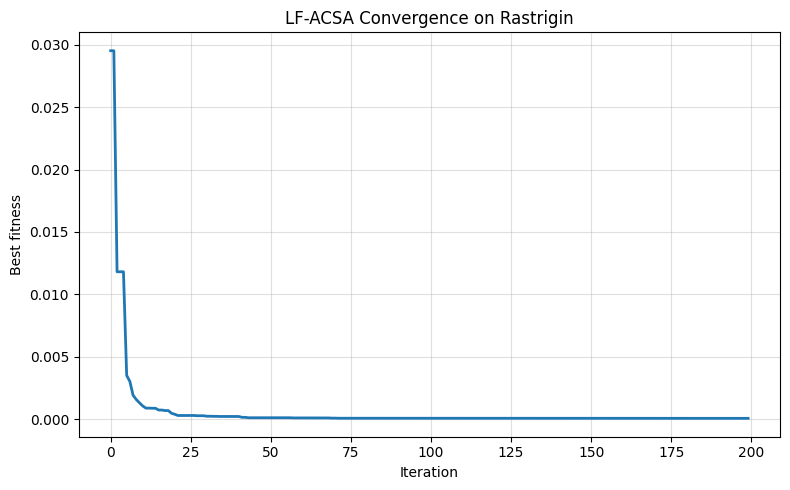

In [8]:
# --- Convergence plot ---
plt.figure(figsize=(8, 5))
plt.plot(convergence, linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Best fitness")
plt.title("Convergence")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()